In [105]:
import importlib, tools
importlib.reload(tools)
from tools import plot_surface, read_cloud, create_surface_mesh, plot_points, save_cloud, px_to_inch

# %matplotlib qt
%matplotlib inline

In [131]:
import numpy as np


def ransac_fit_plane(
    voxels: np.ndarray, thresh=0.1, maxIteration=100
):
    """Fits a plane to points using the RANSAC algorithm

    Args:
        voxels (np.ndarray): N x 3 array of points to fit the plane
        inlier_thresh (float, optional): distance from the plane for filtering the inliers. Defaults to 0.1.
        maxIteration (int, optional): number of iterations. Defaults to 100.

    Returns:
        np.ndarray: array of coefficients for A*x+B*y+C*z+D=0 equation
        np.ndarray: indexes of inliers for the returned plane

    """
    out_inliers = []
    out_fit = np.zeros(4)
    for _ in range(maxIteration):
        pts = voxels[np.random.choice(voxels.shape[0], 3, replace=False)]
        v_a = pts[0] - pts[2]
        v_b = pts[1] - pts[2]
        norm_a = v_a / np.linalg.norm(v_a)
        norm_b = v_b / np.linalg.norm(v_b)
        v_plane = np.cross(norm_a, norm_b)  # A,B,C coefficients
        v_plane = v_plane / np.linalg.norm(v_plane)  # normalize plane vector
        D_plane = -np.sum(np.multiply(v_plane, pts[2]))
        distances = calc_plane_distance(voxels, np.array([*v_plane, D_plane]))
        inliers = np.where(distances < thresh)[0]
        if inliers.shape[0] > len(out_inliers):
            out_inliers = inliers
            out_fit = [*v_plane, D_plane]
    return np.array(out_fit), out_inliers


def calc_plane_distance(voxels: np.ndarray, fit: np.ndarray):
    """Calculates distances of points from the plane

    Args:
        voxels (np.ndarray): N x m array of points in m-dimensional space
        fit (np.ndarray): 1 x m element array of plane coefficients
    """
    return np.abs((np.matmul(voxels, fit[:-1]) + fit[-1]) / np.linalg.norm(fit[:-1]))

In [108]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


def run_k_means(conf, n_clusters: int | None = None):
    fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'})
    multicloud = np.concatenate(
        [
            read_cloud(f"../clouds/{fname}.xyz") + translate_vector
            for fname, translate_vector in conf
        ]
    )
    ax, fig = plot_points(
        voxels=multicloud,
        ax=axes[0]
    )
    ax.set_title("Test cloud built from primitives")

    clusterer = KMeans(n_clusters=n_clusters or len(conf))
    clusters = clusterer.fit_predict(multicloud)

    for idx in np.unique(clusters):
        ax, fig = plot_points(
            voxels=multicloud[clusters == idx], ax=axes[1], label=f"cluster {idx}")

    ax.set_title(
        f"Clouds grouped by k-means into {n_clusters or len(conf)} clusters")
    ax.legend()
    fig.set_size_inches(px_to_inch(1000, 700))
    plt.show()

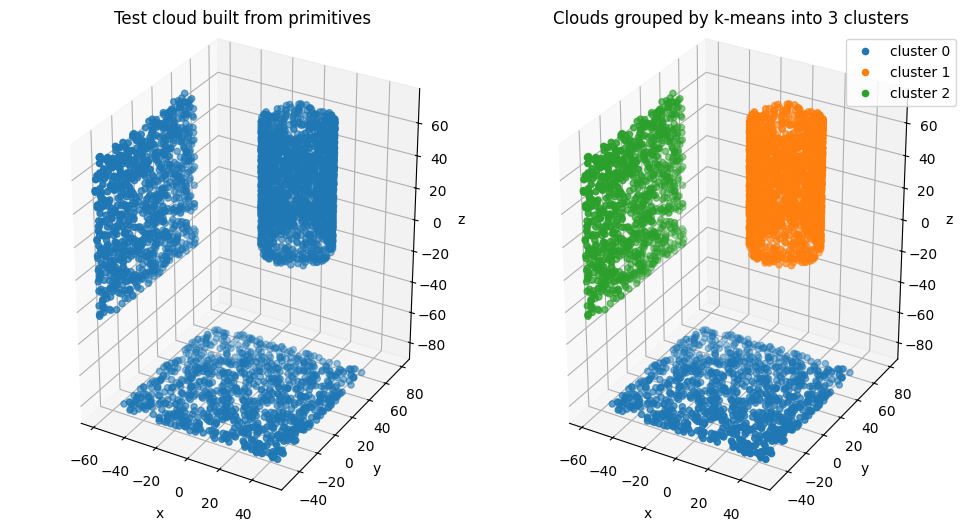

In [109]:
# chmury źródłowe rozłączone z dużymi odstępami
conf = [
    ["z_plane", np.array([0, 0, -80])],
    ["x_plane", np.array([-60, 0, 20])],
    ["cylinder", np.array([0, 60, 20])],
]

run_k_means(conf)

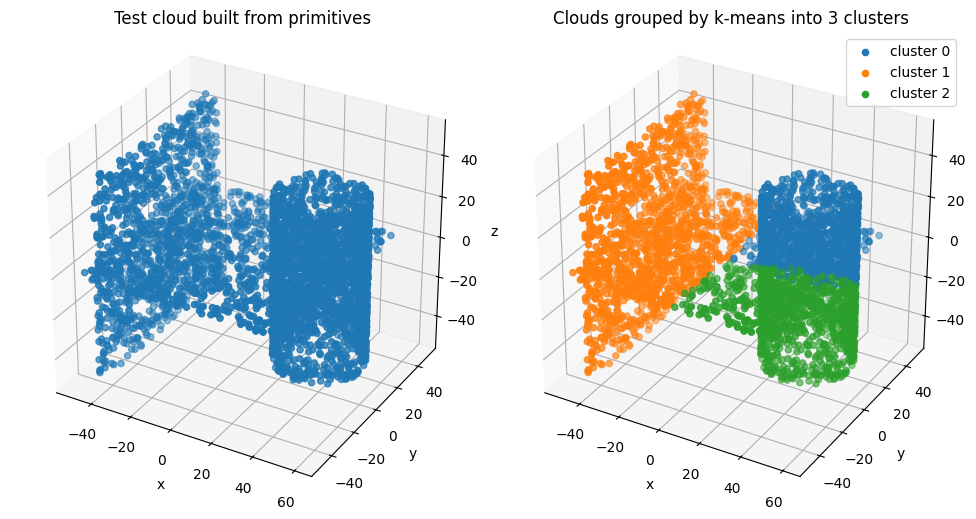

In [110]:
# chmury częściowo zagnieżdżone
conf = [
    ["z_plane", np.array([0, 0, 0])],
    ["x_plane", np.array([-40, 0, 0])],
    ["cylinder", np.array([40, 0, 0])],
]

run_k_means(conf)

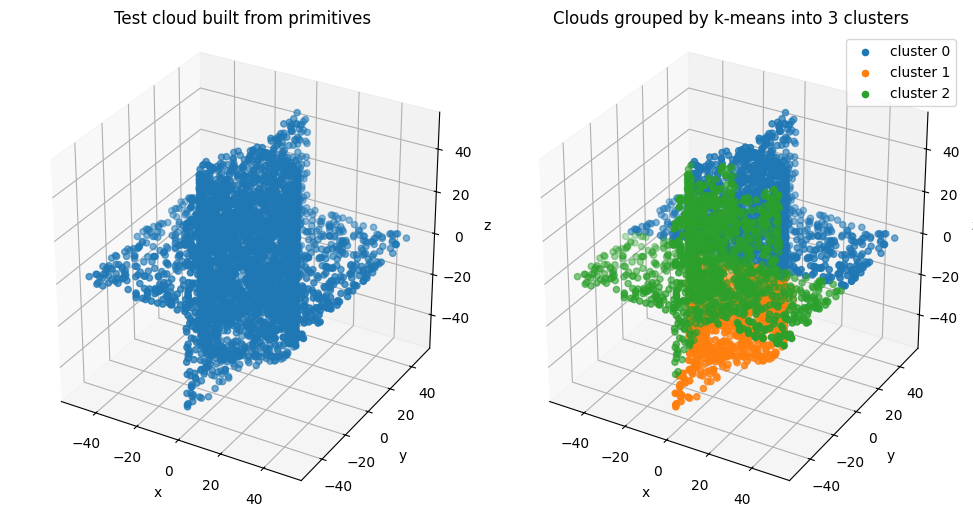

In [115]:
# chmury zagnieżdżone w sobie
conf = [
    ["z_plane", np.array([0, 0, 0])],
    ["x_plane", np.array([0, 0, 0])],
    ["cylinder", np.array([0, 0, 0])],
]

run_k_means(conf)

In [127]:
def run_ransac(voxels):
    ax, fig = plot_points(voxels=voxels)

    fit, inliers = ransac_fit_plane(voxels)

    def z_calc_mesh(x, y):
        return -(fit[0] / fit[2] * x + fit[1] / fit[2] * y + fit[3] / fit[2])

    def classify_fit():
        if inliers.shape[0] < 0.7 * voxels.shape[0]:
            return "not a plane"
        elif abs(fit[2]) > 0.8:
            return "a horizontal plane"
        return "a vertical plane"

    print(
        "Equation: {:.2f}*x + ({:.2f}*y) + ({:.2f}*z) + ({:.2f}) = 0;\tCloud is {}".format(
            *fit, classify_fit()
        )
    )

    ax, fig = plot_surface(
        *create_surface_mesh(
            (voxels[:, 0].min(), voxels[:, 0].max()),
            (voxels[:, 1].min(), voxels[:, 1].max()),
            z_calc_mesh,
            10,
        ),
        ax=ax,
        color=ax.collections[-1].get_facecolor()[0][:3],
        alpha=0.4,
    )

    for i, f in enumerate([ax.set_xlim3d, ax.set_ylim3d, ax.set_zlim3d]):
        f(np.min(voxels[:, i]), np.max(voxels[:, i]))
    ax.set_aspect("equal", "box")
    plt.show()

Trying to fit a plane to 'x_plane' cloud:
Equation: 1.00*x + (-0.00*y) + (-0.00*z) + (0.01) = 0;	Cloud is a vertical plane


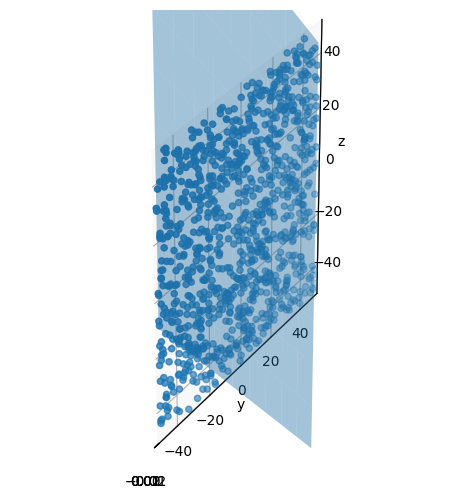

Trying to fit a plane to 'cylinder' cloud:
Equation: -0.27*x + (0.96*y) + (-0.02*z) + (-19.64) = 0;	Cloud is not a plane


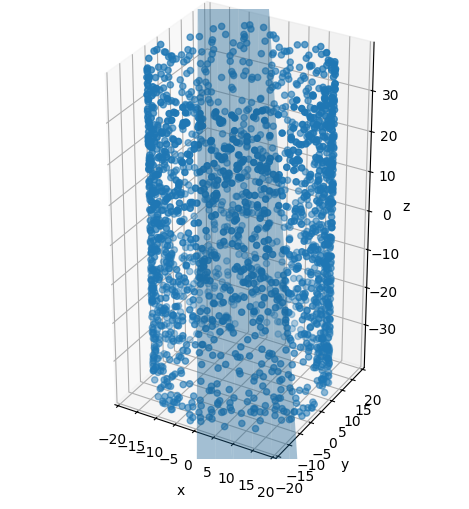

Trying to fit a plane to 'y_plane' cloud:
Equation: -0.00*x + (1.00*y) + (-0.00*z) + (-0.00) = 0;	Cloud is a vertical plane


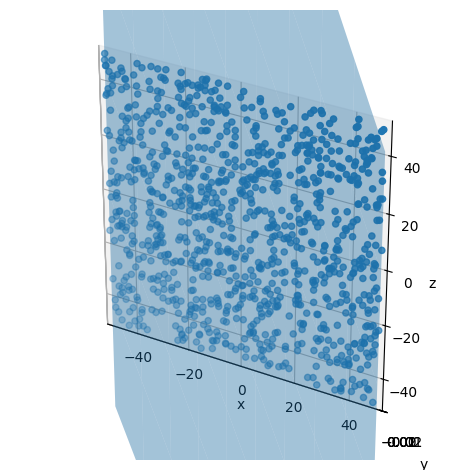

Trying to fit a plane to 'z_plane' cloud:
Equation: 0.00*x + (-0.00*y) + (-1.00*z) + (-0.02) = 0;	Cloud is a horizontal plane


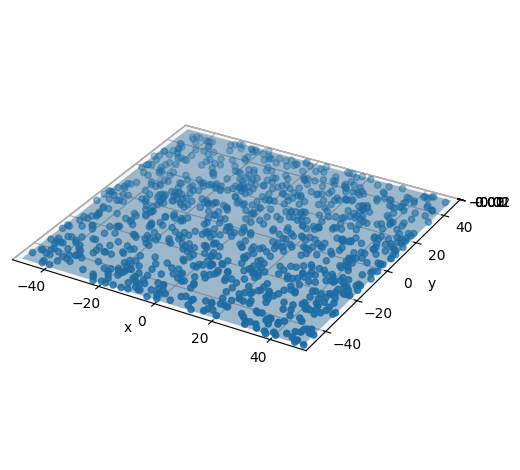

In [133]:
for cloud in ('x_plane', 'cylinder', 'y_plane', 'z_plane'):
     voxels = read_cloud(f'../clouds/{cloud}.xyz')
     print(f'Trying to fit a plane to \'{cloud}\' cloud:')
     run_ransac(voxels)

In [ ]:
from pyransac3d import Plane

room_full = read_cloud("../clouds/conferenceRoom_1.txt", delimiter=" ")

iter = 6
ax = None
for i in range(iter):
    equation, inliers = Plane().fit(
        room_full[:, 0:3], thresh=0.05, maxIteration=200)
    print(
        "Equation of plane {} with {} inliers: {:.2f}*x + ({:.2f}*y) + ({:.2f}*z) + ({:.2f}) = 0".format(
            i, inliers.shape[0], *equation
        )
    )
    save_cloud(f"../clouds/room_clouds/plane_{i}.xyz", room_full[inliers])
    room_full = np.delete(room_full, inliers, axis=0)

Equation of plane 0 with 127311 inliers: -0.04*x + (0.01*y) + (1.00*z) + (-4.20) = 0
Equation of plane 1 with 197397 inliers: 0.00*x + (0.01*y) + (1.00*z) + (-0.28) = 0
Equation of plane 2 with 140740 inliers: -0.00*x + (1.00*y) + (0.01*z) + (-36.85) = 0
Equation of plane 3 with 140894 inliers: 0.01*x + (1.00*y) + (-0.02*z) + (-41.00) = 0
Equation of plane 4 with 65499 inliers: 1.00*x + (-0.00*y) + (-0.03*z) + (15.46) = 0
Equation of plane 5 with 100544 inliers: 1.00*x + (0.00*y) + (0.00*z) + (20.43) = 0


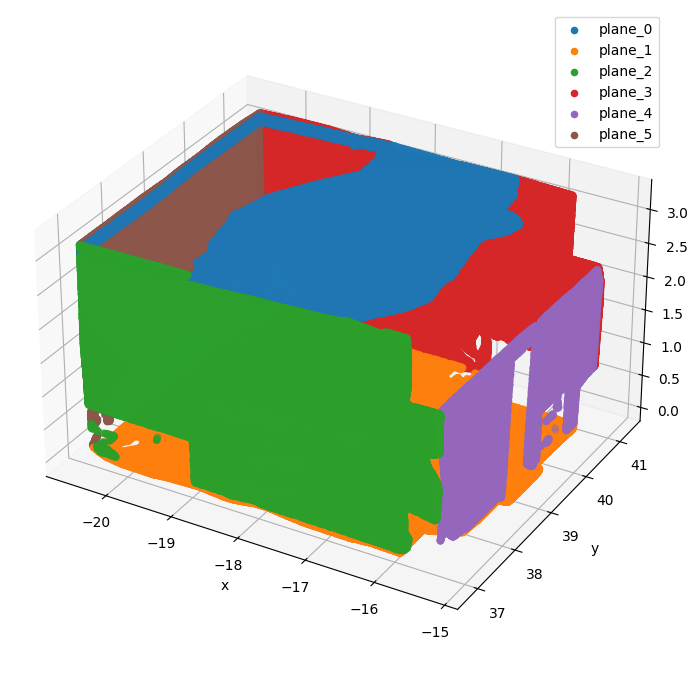

In [ ]:
import os

ax = None
for cloud_file in os.listdir("../clouds/room_clouds"):
    plane_x = read_cloud(f'../clouds/room_clouds/{cloud_file}')
    ax, fig = plot_points(
        voxels=plane_x[:, 0:3], label=cloud_file.split('.')[0], ax=ax)
lg = ax.legend()
fig.set_size_inches(px_to_inch(1000, 700))